In [15]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Done


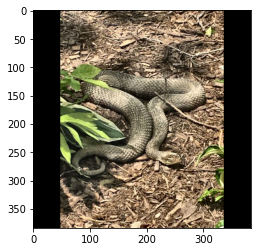

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/5-class.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

picture = plt.imread('/content/5-class/preprocessed-cleaned-set/train/class-1/00056e9548477cda7a885bb423cb668c.jpg')
imageShow = plt.imshow(picture)

In [5]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [6]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            ResNetBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResNetBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [3]:
# resnet18Model = ResNet_18(3, 5) 
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 5 
# 5 classes for dataset1
resnet18Model.fc = nn.Linear(num_filters,num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)
resnet18Model.load_state_dict(torch.load('/content/82-epoch-output.pt'))


# change classes based on data set used
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(resnet18Model)
# summary(model,input_size=(3,32,32))


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


11179077

ResNet_18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNor

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18Model.parameters(), lr=0.0001,weight_decay=1e-4)
# weight_decay=1e-4
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [4]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/5-class/preprocessed-cleaned-set/train/'
test_path = '/content/5-class/preprocessed-cleaned-set/test'
val_path = '/content/5-class/preprocessed-cleaned-set/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)

    mean, std = get_mean_std(train_Loader)

    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)


    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(data_loader_train):
    batch=next(iter(data_loader_train))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)




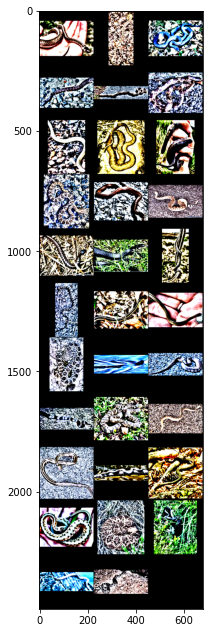

labels: tensor([2, 4, 3, 0, 3, 3, 2, 0, 1, 4, 2, 4, 2, 1, 1, 3, 1, 2, 4, 0, 0, 3, 0, 4,
        3, 0, 0, 2, 4, 3, 2, 4])


In [5]:
data_loader_train,data_loader_test,data_loader_val = transformDS1(32,224)
show_transformed_images(data_loader_val)


In [25]:
############ Define the training loop here ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
resnet18Model.to(device)
num_epochs = 10
Accuracy=[]
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = resnet18Model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Training accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            validation_accuracy = 0
            resnet18Model.eval()
            with torch.no_grad(): 
                val_correct = 0
                val_total = 0
                for data in data_loader_val:
                    images, val_labels = data[0].to(device), data[1].to(device)
                    outputs = resnet18Model(images)
                    # Validation set accuracy
                    val_total = val_labels.size(0)
                    _,predicted = torch.max(outputs.data, 1)
                    val_correct += (predicted == val_labels).sum().item()
                    val_total  += val_labels.size(0)

            validation_accuracy = 100 * (val_correct / val_total)
            training_accuracy = (correct / total) * 100
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), training_accuracy , validation_accuracy))
            Accuracy.append(training_accuracy)
                            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
torch.save(resnet18Model.state_dict(), "/content/5-epoch-output.pt")

Device: cuda:0
Epoch [1/10], Step [200/381], Loss: 0.8933, Training Accuracy: 65.62%, Validation Accuracy: 5440.00%
Epoch [1/10], Step [300/381], Loss: 0.8730, Training Accuracy: 68.75%, Validation Accuracy: 5425.00%
Epoch [2/10], Step [100/381], Loss: 0.9322, Training Accuracy: 71.88%, Validation Accuracy: 5702.50%
Epoch [2/10], Step [200/381], Loss: 1.0077, Training Accuracy: 68.75%, Validation Accuracy: 5462.50%
Epoch [2/10], Step [300/381], Loss: 0.8485, Training Accuracy: 65.62%, Validation Accuracy: 5640.00%
Epoch [3/10], Step [100/381], Loss: 1.0463, Training Accuracy: 62.50%, Validation Accuracy: 5660.00%
Epoch [3/10], Step [200/381], Loss: 0.9482, Training Accuracy: 59.38%, Validation Accuracy: 5700.00%
Epoch [3/10], Step [300/381], Loss: 1.0020, Training Accuracy: 50.00%, Validation Accuracy: 5530.00%
Epoch [4/10], Step [100/381], Loss: 0.9613, Training Accuracy: 53.12%, Validation Accuracy: 5750.00%
Epoch [4/10], Step [200/381], Loss: 0.8058, Training Accuracy: 65.62%, Valid

KeyboardInterrupt: ignored

In [ ]:
# torch.save(model.state_dict(), "./content/drive/MyDrive")

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
resnet18Model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18Model(images)
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Device: cuda:0
Test Accuracy of the model on the 1744 test images: 71.21559633027523 %


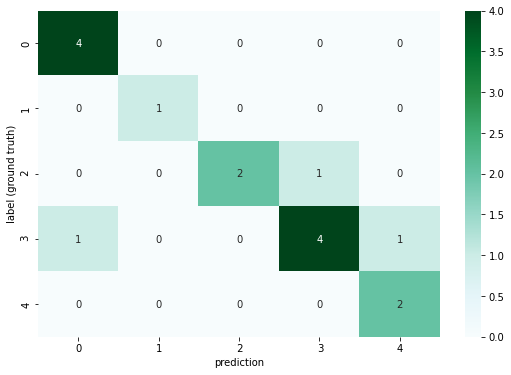

In [9]:
# prediction = resnet18Model(data_loader_test)
# print(prediction)
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['0', '1', ' 2', ' 3', '4']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in data_loader_test:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet18Model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', ' 2', ' 3', '4')

# Build confusion matrix
confusion_matrix(y_true, y_pred)
# cf_matrix
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

array([[221,   7,   9,  57,  16],
       [ 35, 238,  28,  51,  15],
       [ 31,   8, 280,  24,  13],
       [ 56,  16,  18, 229,  27],
       [ 37,   6,  10,  38, 274]])

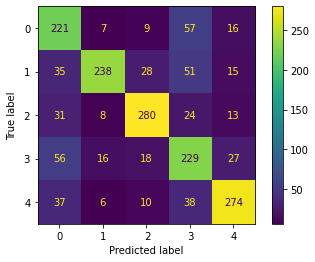

In [16]:
class_names = ['0', '1', ' 2', ' 3', '4']

disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                              display_labels=class_names)
disp.plot()

plt.show()